In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Dropout

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('nyc_taxi_data.csv')
df['timestamp'] = pd.to_datetime(df.timestamp, unit='s')
df['timestamp'].groupby([df.timestamp.dt.year]).agg('count')

timestamp
2001       3
2002       1
2003       4
2008       9
2009      19
2016    8793
2017    8766
2018      20
2041       1
2053       1
Name: timestamp, dtype: int64

In [3]:
df.describe()

,passenger_count,trip_distance,total_amount,humidity,pressure,temperature,wind_direction,wind_speed
count,17617.000000,1.761700e+04,1.761700e+04,15999.000000,15999.000000,15999.000000,15999.000000,15999.000000
mean,22826.868252,5.440456e+04,2.274162e+05,65.284768,1017.387087,286.702957,189.917370,3.301706
std,10768.365771,3.308981e+05,1.065534e+05,20.913299,8.071362,9.828138,110.912245,2.088770
min,1.000000,-3.337066e+06,2.300000e+00,10.000000,988.000000,255.070000,0.000000,0.000000
25%,14409.000000,2.980201e+04,1.420672e+05,49.000000,1013.000000,278.890000,80.000000,2.000000
50%,25483.000000,4.459818e+04,2.539055e+05,65.000000,1017.000000,287.440000,210.000000,3.000000
75%,30330.000000,5.257208e+04,3.024059e+05,83.000000,1022.000000,294.850000,287.000000,4.000000
max,59077.000000,1.913556e+07,1.550589e+06,100.000000,1044.000000,308.370000,360.000000,18.000000


Also, since we have been provided with hourly NYC Yellow Cab trip record data from January 2016 to December 2017, ignore every other year

In [4]:
correct_df = df[(df.timestamp > '2015-12-31') & (df.timestamp < '2018-01-01')]
correct_df['timestamp'].groupby([correct_df.timestamp.dt.year]).agg('count')

timestamp
2016    8793
2017    8766
Name: timestamp, dtype: int64

In [5]:
correct_df = correct_df.set_index('timestamp')
correct_df.sort_index(inplace=True)

Convert temperature from kelvin to celcius for easy interpretation

In [6]:
correct_df['temperature'] = correct_df.temperature.apply(lambda x: x - 273.15)

Check for missing values

In [7]:
correct_df.isnull().sum()

passenger_count           0
trip_distance             0
total_amount              0
humidity               1560
pressure               1560
temperature            1560
weather_description    1560
wind_direction         1560
wind_speed             1560
dtype: int64

In [8]:
correct_df[correct_df.isna().any(axis=1)].head()

,passenger_count,trip_distance,total_amount,humidity,pressure,temperature,weather_description,wind_direction,wind_speed
timestamp,,,,,,,,,
2017-10-28 01:00:00,24829,41749.11,225081.08,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-28 02:00:00,20934,35478.33,188364.27,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-28 03:00:00,15350,27715.91,140775.03,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-28 04:00:00,10226,21703.44,100530.75,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-28 05:00:00,5007,14690.83,63623.90,NaN,NaN,NaN,NaN,NaN,NaN


The missing values are from the humidity, pressure, temperature, weather_description, wind_direction and wind_speed columns. Also, from my observations, the missing values are from 28th October 2017 till the 31st October 2017

Some options are:

- remove these rows (by ignoring the dates identified)
- use only the passenger_count, trip_distance and total_amount columns
- fill the missing values (using a statistical measure e.g mean)

In [9]:
forecast_df = correct_df[(correct_df.index < '2017-10-28')]

In [10]:
forecast_df.isnull().sum()

passenger_count        0
trip_distance          0
total_amount           0
humidity               0
pressure               0
temperature            0
weather_description    0
wind_direction         0
wind_speed             0
dtype: int64

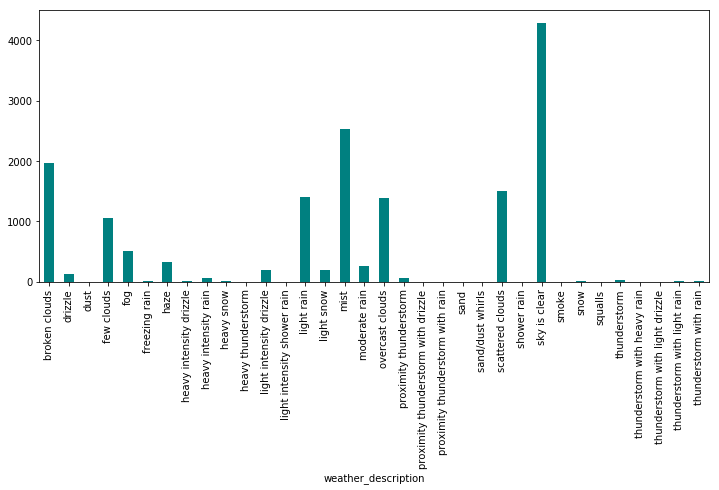

In [11]:
plt.figure(figsize=(12, 5))
forecast_df.groupby('weather_description').count()['passenger_count'].plot(kind='bar', color='teal')

The sky is clear on most days

In [12]:
forecast_df = forecast_df.drop('weather_description', axis=1)

In [13]:
forecast_df.head()

,passenger_count,trip_distance,total_amount,humidity,pressure,temperature,wind_direction,wind_speed
timestamp,,,,,,,,
2016-01-01 00:00:00,46211,74348.37,391952.49,65.0,1019.0,6.390000,270.0,3.0
2016-01-01 01:00:00,52387,89534.36,462070.59,73.0,1019.0,6.268535,270.0,3.0
2016-01-01 02:00:00,46179,86704.54,427565.82,100.0,1020.0,5.880000,270.0,4.0
2016-01-01 03:00:00,38057,75976.10,361939.82,89.0,1019.0,5.723939,279.0,4.0
2016-01-01 04:00:00,27840,58138.22,270881.18,56.0,1019.0,5.200000,310.0,4.0


In [14]:
forecast_df.describe()

,passenger_count,trip_distance,total_amount,humidity,pressure,temperature,wind_direction,wind_speed
count,15998.000000,1.599800e+04,1.599800e+04,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000
mean,23102.832729,5.631704e+04,2.299978e+05,65.285223,1017.386923,13.553065,189.929241,3.301788
std,10755.874650,3.471400e+05,1.060674e+05,20.913874,8.071587,9.828436,110.905546,2.088810
min,9.000000,-3.337066e+06,1.208500e+02,10.000000,988.000000,-18.080000,0.000000,0.000000
25%,14846.500000,3.076645e+04,1.468287e+05,49.000000,1013.000000,5.740000,80.000000,2.000000
50%,25683.000000,4.504809e+04,2.555846e+05,65.000000,1017.000000,14.290000,210.000000,3.000000
75%,30577.000000,5.307184e+04,3.041992e+05,83.000000,1022.000000,21.700000,287.000000,4.000000
max,59077.000000,1.913556e+07,1.550589e+06,100.000000,1044.000000,35.220000,360.000000,18.000000


A few glaring observations
- Why is there a huge difference between the minimum and maximum number of passengers?  9 - 59077?
- Is it possible to have no wind direction or speed (maybe there was no wind)
- Why is there a negative trip distance?




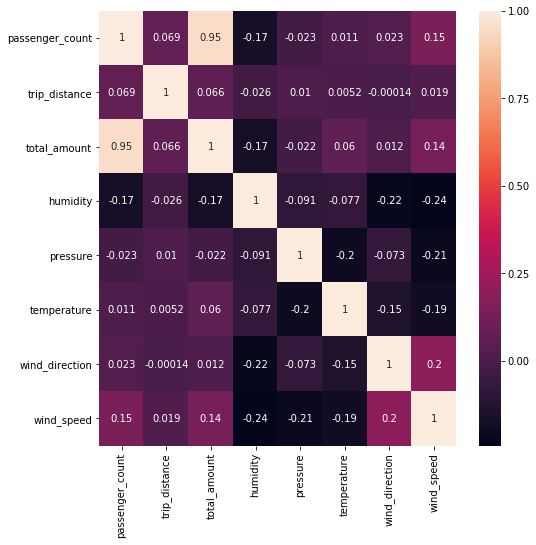

In [15]:
corr = forecast_df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

    The heatmap above shows that there is a strong positive correlation between the total amount and the number of passengers

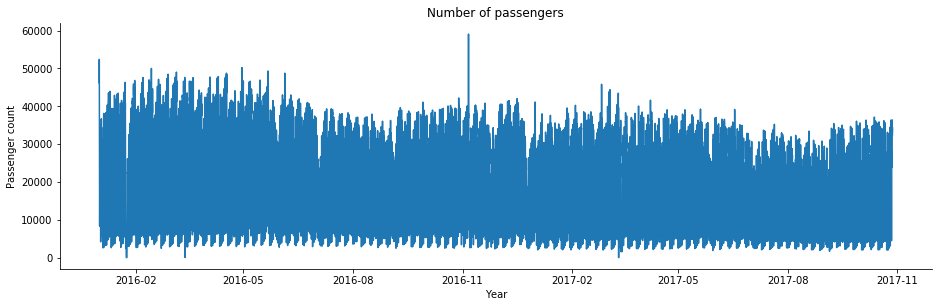

In [17]:
passengers = forecast_df[['passenger_count']]

plt.figure(figsize=(13, 4))
plt.plot(passengers)
plt.tight_layout()
sns.despine(top=True)
plt.title("Number of passengers")
plt.xlabel("Year")
plt.ylabel("Passenger count")
plt.show()

In [18]:
forecast_df.index.groupby(forecast_df.index.year)

{2016: DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
                '2016-01-01 02:00:00', '2016-01-01 03:00:00',
                '2016-01-01 04:00:00', '2016-01-01 05:00:00',
                '2016-01-01 06:00:00', '2016-01-01 07:00:00',
                '2016-01-01 08:00:00', '2016-01-01 09:00:00',
                ...
                '2016-12-31 14:00:00', '2016-12-31 15:00:00',
                '2016-12-31 16:00:00', '2016-12-31 17:00:00',
                '2016-12-31 18:00:00', '2016-12-31 19:00:00',
                '2016-12-31 20:00:00', '2016-12-31 21:00:00',
                '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
               dtype='datetime64[ns]', name='timestamp', length=8793, freq=None),
 2017: DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 01:00:00',
                '2017-01-01 02:00:00', '2017-01-01 03:00:00',
                '2017-01-01 04:00:00', '2017-01-01 05:00:00',
                '2017-01-01 06:00:00', '2017-01-01 07:00:00',
                '

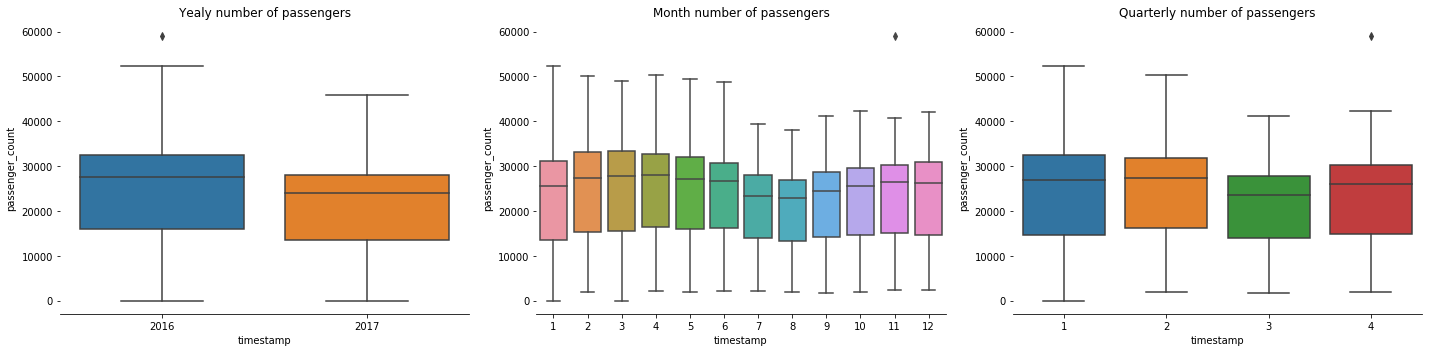

In [19]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.boxplot(passengers.index.year, passengers.passenger_count)
sns.despine(left=True)
plt.title('Yealy number of passengers')
plt.tight_layout()

plt.subplot(1,3,2)
sns.boxplot(passengers.index.month, passengers.passenger_count)
sns.despine(left=True)
plt.title('Month number of passengers')
plt.tight_layout()

plt.subplot(1,3,3)
sns.boxplot(passengers.index.quarter, passengers.passenger_count)
sns.despine(left=True)
plt.title('Quarterly number of passengers')
plt.tight_layout()

- The statistics for the yearly number of passengers are seen to be higher in 2016 as opposed to 2017 however, this can be because there are more values in the former.
- July and August are the months with the lowest statistics
- In each year, the third quarter has the lowest number of passengers
- There is a single outlier that is seen across all three plots with over 55000 number of passengers in November

Let's try to get rid of this data point

In [20]:
outlier_row = forecast_df[(forecast_df.passenger_count > 55000)].index
forecast_df = forecast_df.drop(outlier_row)
passengers = forecast_df[['passenger_count']]

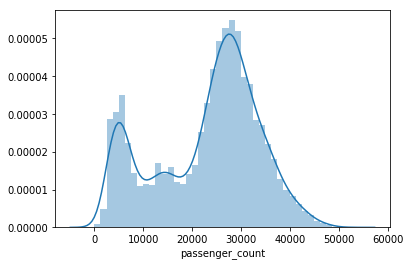

In [22]:
sns.distplot(forecast_df.passenger_count)

In [23]:
print('Kurtosis: {}'.format(stats.kurtosis(passengers.passenger_count)))
print('Skewness: {}'.format(stats.skew(passengers.passenger_count)))

Kurtosis: -0.760635589496454
Skewness: -0.4218090262572425


    Fairly symmetical with light tails. passenger_count is almost a normal distribution

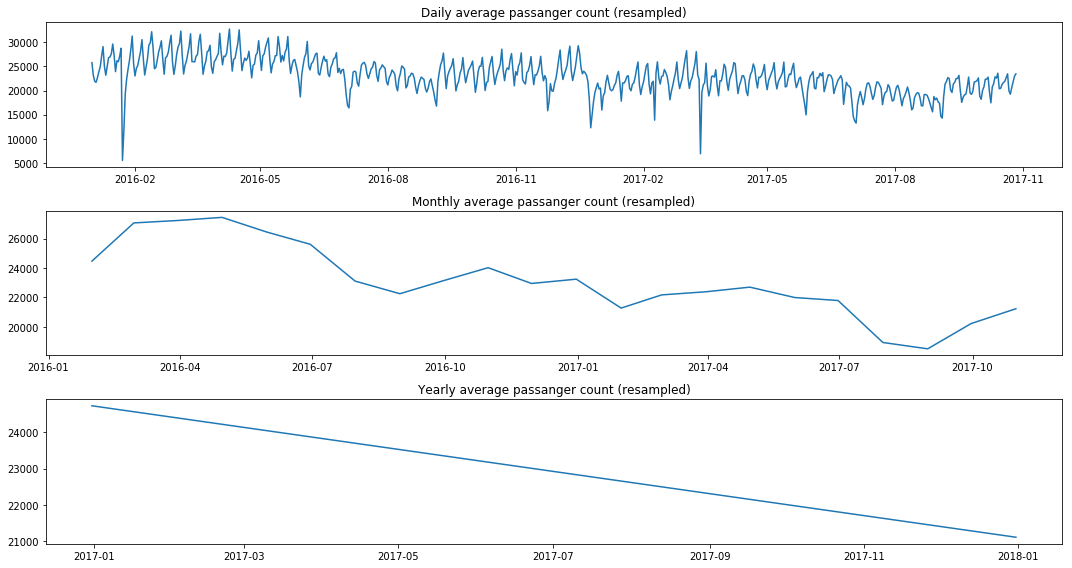

In [24]:
plt.figure(figsize=(15,8))
plt.subplot(3,1,1)
plt.plot(passengers.resample('D').mean())
plt.title('Daily average passanger count (resampled)')
plt.tight_layout()

plt.subplot(3,1,2)
plt.plot(passengers.resample('M').mean())
plt.title('Monthly average passanger count (resampled)')
plt.tight_layout()

plt.subplot(3,1,3)
plt.plot(passengers.resample('Y').mean())
plt.title('Yearly average passanger count (resampled)')
plt.tight_layout()

Overall, from the plots above, there is a common pattern in both years

A common assumption for time series data is that it is stationary i.e. its summary statistics (e.g. mean, variance) do not vary with time.

Let's test for stationarity of the data. 

1. Augmented Dickey-Fuller (ADF) test: it is a unit root statistical test in which the null hypothesis (H0) assumes that the data is non-stationary. Low p-values indicate stationarity. 

    Significance level assumed is 0.05 (5%)

In [25]:
adf_test = adfuller(passengers.passenger_count)
print('ADF statistic: {}'.format(adf_test[0]))
print('p-value: {}'.format(adf_test[1]))
print('critical values:')
for k, v in adf_test[4].items():
    print('\t{}: {}'.format(k, v))

ADF statistic: -11.280399110999742
p-value: 1.461038527998985e-20
critical values:
	1%: -3.430759976338494
	5%: -2.8617211926008874
	10%: -2.5668664443101443


Here, p-value < 0.05 so we reject the null hypothesis that the data is non-stationary

2. Confirm the statistics with a plot: mean and standard deviation

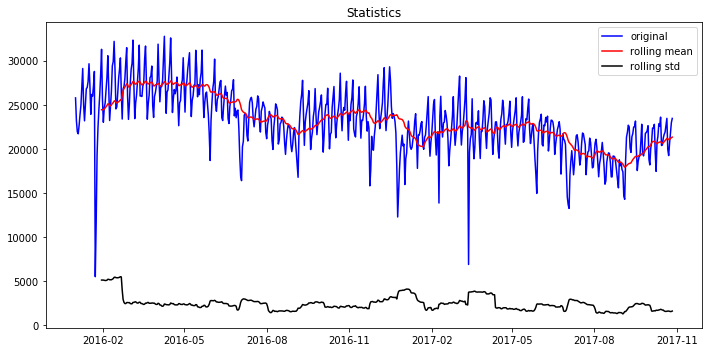

In [26]:
passengers_resampled = passengers.resample('D', how=np.mean) # I resampled to days here to allow for easy plotting.

rolling_mean =passengers_resampled.rolling(window=30).mean() 
rolling_std = passengers_resampled.rolling(window=30).std()

plt.figure(figsize=(10,5))
plt.plot(passengers_resampled, color="blue", label="original")
plt.plot(rolling_mean, color="red", label="rolling mean")
plt.plot(rolling_std, color="black", label="rolling std")

plt.legend(loc="best")
plt.title("Statistics")
plt.tight_layout()
plt.show()

The plot above confirms the results from the previous ADF test

## Let's Forecast!

To forecast, Long Short Term Memory (LSTM) will be used because, it works well with sequence to sequence data which can be likened to time series.


The problem can be viewed as a supervised learning problem with passenger_count as the target variable and other features as predictors.

In [27]:
def convert_ts_to_supervised_df(df, lag=1, current_state=1): #lag for every hour
    num_feats = df.shape[1]
    features, feature_names = [], []
    for i in range(lag, 0, -1): #previous lags
        features.append(df.shift(i)) #Shift index by desired number of period
        feature_names.extend(['{}(t-{})'.format(df.columns[j], i) for j in range(num_feats)])
    
    for i in range(0, current_state):
        features.append(df.shift(-i))
        feature_names.extend(['{}(t)'.format(df.columns[j]) for j in range(num_feats)])
    
    shifted_df = pd.concat(features, axis=1)
    shifted_df.columns = feature_names
    shifted_df.dropna(inplace=True)
    
    return shifted_df

Shifted the every datapoint backwards by a 1 hour

In [28]:
shifted_fsdf = convert_ts_to_supervised_df(forecast_df)
drop_columns = ['trip_distance(t)', 'total_amount(t)', 'humidity(t)', 'pressure(t)',
               'temperature(t)', 'wind_direction(t)', 'wind_speed(t)']

#the only column we are predicting is passenger_count
shifted_fsdf = shifted_fsdf.drop(drop_columns, axis=1) 
shifted_fsdf.head()

,passenger_count(t-1),trip_distance(t-1),total_amount(t-1),humidity(t-1),pressure(t-1),temperature(t-1),wind_direction(t-1),wind_speed(t-1),passenger_count(t)
timestamp,,,,,,,,,
2016-01-01 01:00:00,46211.0,74348.37,391952.49,65.0,1019.0,6.390000,270.0,3.0,52387
2016-01-01 02:00:00,52387.0,89534.36,462070.59,73.0,1019.0,6.268535,270.0,3.0,46179
2016-01-01 03:00:00,46179.0,86704.54,427565.82,100.0,1020.0,5.880000,270.0,4.0,38057
2016-01-01 04:00:00,38057.0,75976.10,361939.82,89.0,1019.0,5.723939,279.0,4.0,27840
2016-01-01 05:00:00,27840.0,58138.22,270881.18,56.0,1019.0,5.200000,310.0,4.0,14338


Training set = 75%
Test set = 25%

In [29]:
len_train1 = int(0.75 * len(shifted_fsdf))
train1, test = shifted_fsdf.iloc[:len_train1, :], shifted_fsdf.iloc[len_train1:, :] #split to train and test

len_train2 = int(0.70 * len(train1))
train2, val = train1.iloc[:len_train2, :], train1.iloc[len_train2:, :] #split to train and val

In [30]:
scaler = MinMaxScaler()

train2 = pd.DataFrame(scaler.fit_transform(train2), columns=shifted_fsdf.columns, index=train2.index)
val = pd.DataFrame(scaler.transform(val), columns=shifted_fsdf.columns, index=val.index)
test = pd.DataFrame(scaler.transform(test), columns=shifted_fsdf.columns, index=test.index)

X_train = train2.drop('passenger_count(t)', axis=1)
y_train = train2['passenger_count(t)']

X_val = val.drop('passenger_count(t)', axis=1)
y_val = val['passenger_count(t)']

X_test = test.drop('passenger_count(t)', axis=1)
y_test = test['passenger_count(t)']


print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(8397, 8) (8397,) (3600, 8) (3600,) (3999, 8) (3999,)


A LSTM network expects the input to be in the form [samples, time steps, features] where samples is the 
number of data points we have, time steps is the number of time-dependent steps that are there in a 
single data point.

In this case, our timestep is 1

In [31]:
train_X = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
val_X = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))
test_X = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(train_X.shape, y_train.shape, val_X.shape, y_val.shape, test_X.shape, y_test.shape)

(8397, 1, 8) (8397,) (3600, 1, 8) (3600,) (3999, 1, 8) (3999,)


In [32]:
model = Sequential()
model.add(LSTM(150, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2)) #this avoids overfitting
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, y_train, epochs=20, batch_size=500, \
                    validation_data=(val_X, y_val), shuffle=False)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 8397 samples, validate on 3600 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
8397/8397 [==============================] - 1s 89us/sample - loss: 0.3244 - val_loss: 0.1684
Epoch 2/20
8397/8397 [==============================] - 0s 24us/sample - loss: 0.1728 - val_loss: 0.1409
Epoch 3/20
8397/8397 [==============================] - 0s 21us/sample - loss: 0.1422 - val_loss: 0.1247
Epoch 4/20
8397/8397 [==============================] - 0s 30us/sample - loss: 0.1379 - val_loss: 0.1163
Epoch 5/20
8397/8397 [==============================] - 0s 22us/sample - loss: 0.1277 - val_loss: 0.1070
Epoch 6/20
8397/8397 [==============================] - 0s 19us/sample - loss: 0.1178 - val_loss: 0.0976
Epoch 7/20
8397/8397 [==============================] - 0s 25us/sample - loss: 0.1064 - val_loss: 0.0882
Epoch

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               95400     
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 151       
Total params: 95,551
Trainable params: 95,551
Non-trainable params: 0
_________________________________________________________________


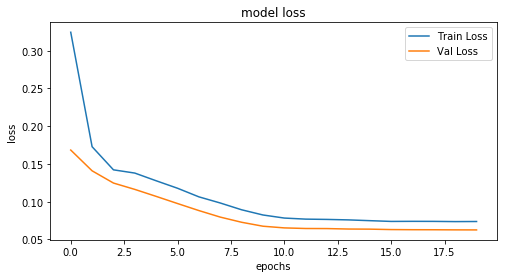

In [34]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='best')
plt.show()

In [35]:
predict_train = model.predict(train_X)
predict_test = model.predict(test_X)

Transfer attributes to a new scaler since we're converting a single column not the entire dataframe as we did earlier

In [36]:
new_scaler = MinMaxScaler()
new_scaler.min_, new_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

In [37]:
predict_train = new_scaler.inverse_transform(predict_train)
y_train = new_scaler.inverse_transform(y_train.values.reshape(-1, 1))
predict_test = new_scaler.inverse_transform(predict_test)
y_test = new_scaler.inverse_transform(y_test.values.reshape(-1, 1))

In [38]:
print('Train MAE: %.3f' % mean_absolute_error(y_train[:, 0], predict_train[:, 0]))
print('Train RMSE: %.3f' % np.sqrt(mean_squared_error(y_train[:, 0], predict_train[:, 0])))

print('\nTest MAE: %.3f' % mean_absolute_error(y_test[:, 0], predict_test[:, 0]))
print('Test RMSE: %.3f' % np.sqrt(mean_squared_error(y_test[:, 0], predict_test[:, 0])))

Train MAE: 3621.100
Train RMSE: 4695.689

Test MAE: 2829.152
Test RMSE: 3679.634


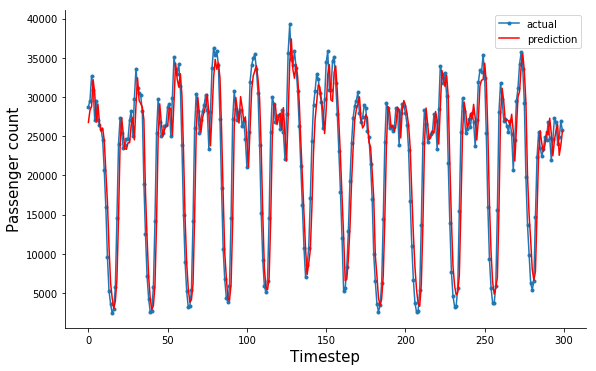

In [39]:
timestep = 300
last_hours = [i for i in range(timestep)]
plt.figure(figsize=(8,5))
plt.plot(last_hours, y_test[:timestep], marker='.', label="actual")
plt.plot(last_hours, predict_test[:timestep], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Passenger count', size=15)
plt.xlabel('Timestep', size=15)
plt.legend(fontsize=10, loc="best")
plt.show();

In [40]:
df = pd.DataFrame(columns=['test_values', 'predicted_values'], index=None)

In [41]:
df.test_values = y_test[:, 0].tolist()
df.predicted_values = predict_test[:, 0].tolist()
df = df.round().astype(int)

In [42]:
df.tail()

,test_values,predicted_values
3994,36386,33607
3995,33118,35406
3996,33436,31771
3997,34460,32491
3998,32431,34001


In [43]:
df.head()

,test_values,predicted_values
0,28791,26760
1,29552,28328
2,32710,28768
3,30850,32209
4,27072,30430
